# Dynamic WSCC 9-bus System with Switch Event

**Authors**:
 - Markus Mirz <mmirz@eonerc.rwth-aachen.de>
 - Steffen Vogel <stvogel@eoner.rwth-aachen.de>

This Jupyter Notebook shows a simple dynamic phasor simulation of the WSCC-9bus benchmark model.
The grid data is loaded from CIM-XML files, while simulation results are stored in CSV files and plotted via Matplotlib

In [20]:
%gui asyncio
#%matplotlib widget

import dpsim
from dpsim.Event import Event
import glob
import asyncio
import matplotlib.pyplot as plt

### Loading Grid Topology from CIM-XML Model

In [21]:
name = 'WSCC-9bus_dyn_switch'
files = glob.glob('../../CIM/WSCC-09_RX_Dyn/*.xml') + \
        glob.glob('Examples/CIM/WSCC-09_RX_Dyn/*.xml')
print(files)
system = dpsim.load_cim(name, files, frequency=60)

['../../CIM/WSCC-09_RX_Dyn/WSCC-09_RX_DI.xml', '../../CIM/WSCC-09_RX_Dyn/WSCC-09_RX_EQ.xml', '../../CIM/WSCC-09_RX_Dyn/WSCC-09_RX_SV.xml', '../../CIM/WSCC-09_RX_Dyn/WSCC-09_RX_TP.xml']


### Rending Network Topology via Graphiz/SVG

We use Graphviz to render the network model into a layouted SVG figure

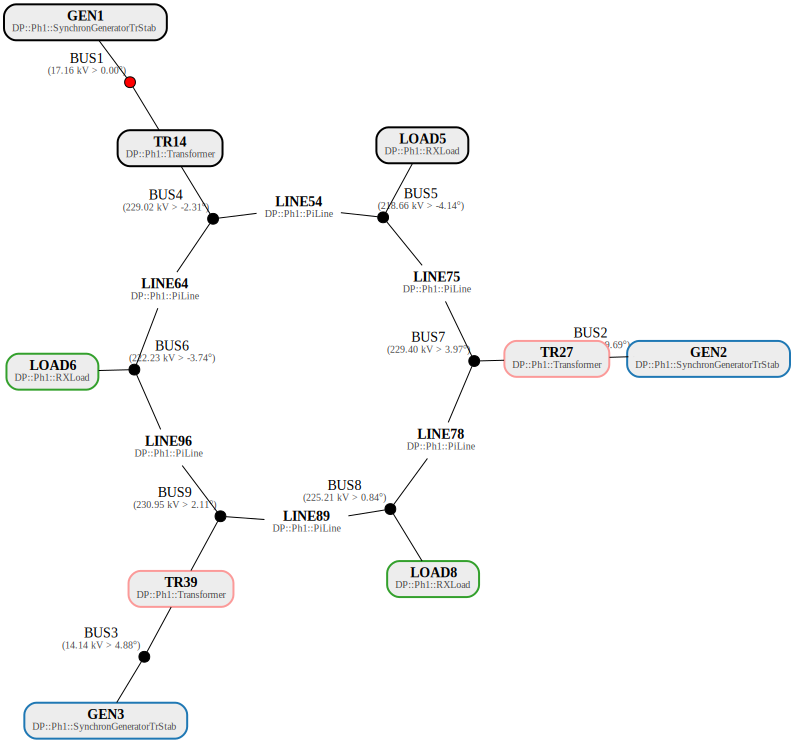

In [22]:
system

### Extending Network with Switch and Load

Here we add a new switch to Bus 9 that is triggered at 0.05s. This component could be added permantely to the CIM model as well using tools like Pintura.

In [23]:
## Switch
sw = dpsim.dp.ph1.Switch("Switch")
sw.R_open = 1e9
sw.R_closed = 0.1
sw.is_closed = False

## Load
load = dpsim.dp.ph1.PQLoadCS("Switched Load")
load.V_nom = 230950
load.P = 30000000
load.Q = 0

## Topology
bus9 = system.nodes["BUS6"]
gnd = dpsim.dp.Node.GND()

sw.connect([ bus9, gnd ])

system.add_component(sw)

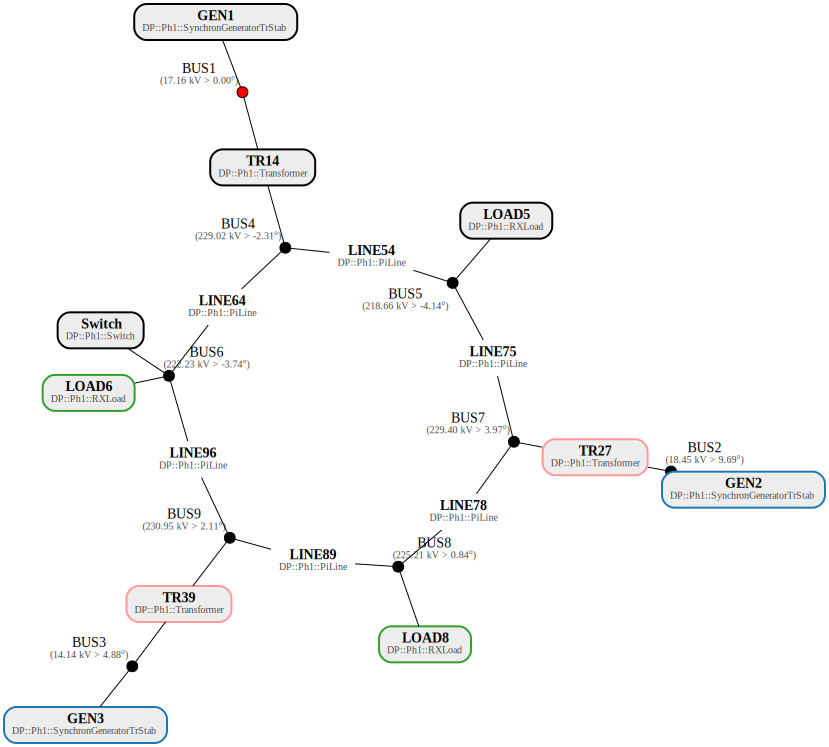

In [24]:
system

### Running Simulation

The actual simulation is done by the C++ DPsim solver. Python is just used for configuration, scripting and analysis

In [25]:
sim = dpsim.Simulation(name, system, timestep=0.0001, duration=2, init_steady_state=True, pbar=True)

#system.components['GEN3'].inertia *= 2
sw.is_closed = False
sim.add_event(0.2, sw, 'is_closed', True)

logger = dpsim.Logger(name)
sim.add_logger(logger)
for i in range(1,4):
	logger.log_attribute(system.components['GEN%d' % i], 'w_r')

for node in system.nodes:
	logger.log_attribute(system.nodes[node], 'v')

sim.start()

HTML(value='Simulation start is pending...')

FloatProgress(value=0.0, max=2.0)

## Analysis

### Read log files and list all column names

In [26]:
import matplotlib.pyplot as plt
import villas.dataprocessing.plottools as pt
import villas.dataprocessing.readtools as rt
from villas.dataprocessing.timeseries import TimeSeries as ts
import numpy as np

res = rt.read_timeseries_dpsim('logs/WSCC-9bus_dyn_switch.csv')

column number: 12
results length: 20001
real column names: ['GEN1.w_r', 'GEN2.w_r', 'GEN3.w_r']
complex column names: ['BUS1.v', 'BUS2.v', 'BUS3.v', 'BUS4.v', 'BUS5.v', 'BUS6.v', 'BUS7.v', 'BUS8.v', 'BUS9.v']


### Phasors at first time step

In [27]:
phasors = ts.phasors(res)
for node, phasor in phasors.items():
    if 'v' in node:
        print(node + ': ' + str(phasor['abs'].values[0]) + '<' + str(phasor['phase'].values[0]))

BUS1.v: 17159.47408273954<-0.014699743011457765
BUS2.v: 18448.55281939392<9.668743971953232
BUS3.v: 14143.99893281713<4.85747242666173
BUS4.v: 229023.74732501165<-2.3268246924779343
BUS5.v: 218644.37933871604<-4.162508862212365
BUS6.v: 222216.70048288885<-3.761448717738632
BUS7.v: 229396.2708230222<3.9473090814217335
BUS8.v: 225188.6066023307<0.8091667274323876
BUS9.v: 230944.17522004995<2.0813440279024853


### Phasors at last time step

In [28]:
for node, phasor in phasors.items():
    if 'v' in node:
        print(node + ': ' + str(phasor['abs'].values[-1]) + '<' + str(phasor['phase'].values[-1]))

BUS1.v: 13025.599417439465<2.240579196953951
BUS2.v: 15123.371768950812<15.292898689071833
BUS3.v: 9422.635086735285<8.83114794252649
BUS4.v: 116767.502798678<-1.3372581362407145
BUS5.v: 126196.32468353372<-0.5270311352448968
BUS6.v: 358.82179009501857<-76.8939728295228
BUS7.v: 163673.2284905621<9.184892675051488
BUS8.v: 144918.6433371336<5.59660956227251
BUS9.v: 126244.30043843512<5.718956918341084


### Phasors at last time step in per unit

BUS1.v: 1.0399681262266387<-0.014699743011457765
BUS2.v: 1.02491960107744<9.668743971953232
BUS3.v: 1.024927458899792<4.85747242666173
BUS4.v: 0.9957554231522245<-2.3268246924779343
BUS5.v: 0.9506277362552872<-4.162508862212365
BUS6.v: 0.966159567316908<-3.761448717738632
BUS7.v: 0.9973750905348792<3.9473090814217335
BUS8.v: 0.979080898271003<0.8091667274323876
BUS9.v: 1.004105109652391<2.0813440279024853


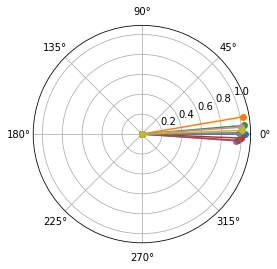

In [29]:
nominal_voltages = {
    'BUS1.v': 16.5e3,
    'BUS2.v': 18e3,
    'BUS3.v': 13.8e3, 
    'BUS4.v': 230e3,
    'BUS5.v': 230e3,
    'BUS6.v': 230e3, 
    'BUS7.v': 230e3,
    'BUS8.v': 230e3,
    'BUS9.v': 230e3
}

plt.figure(1)
for node, nom_voltage in nominal_voltages.items():
    mag = phasors[node]['abs'].values[0] / nom_voltage
    pha = phasors[node]['phase'].values[0]
    print(node + ': ' + str(mag) + '<' + str(pha))
    plt.polar([0, pha / 180 * np.pi], [0, mag], marker='o', label=node)
plt.show()

### Plot node phases

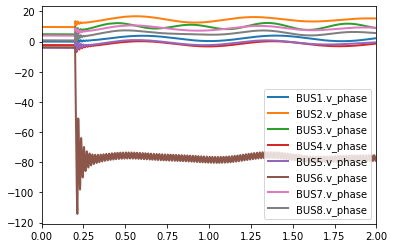

In [30]:
for i in range(1,9):
    pt.plot_timeseries(20, phasors['BUS%d.v' % i]['phase'])

### Plot node voltages

(0.0, 0.06)

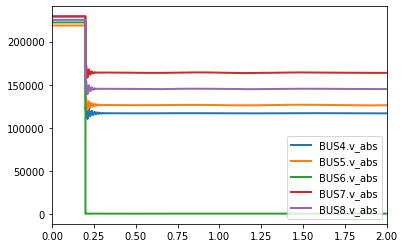

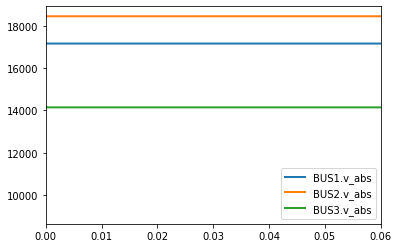

In [31]:
for i in range(4,9):
    pt.plot_timeseries(10, phasors['BUS%d.v' % i]['abs'])
for i in range(1,4):
    pt.plot_timeseries(11, phasors['BUS%d.v' % i]['abs'])
plt.xlim(0.0, 0.06)

Text(0, 0.5, 'mechanical speed (rad/s)')

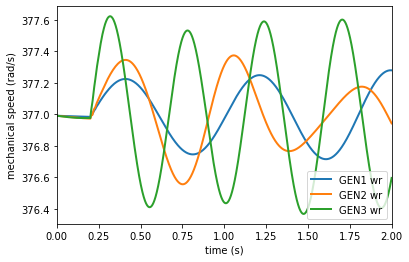

In [32]:
res['GEN1.w_r'].label = 'GEN1 wr'
res['GEN2.w_r'].label = 'GEN2 wr'
res['GEN3.w_r'].label = 'GEN3 wr'
pt.plot_timeseries(1, res['GEN1.w_r'])
pt.plot_timeseries(1, res['GEN2.w_r'])
pt.plot_timeseries(1, res['GEN3.w_r'])
plt.xlabel('time (s)')
plt.ylabel('mechanical speed (rad/s)')

## Validation

In [33]:
# read Simulink log file
import os
import urllib.request

if not os.path.exists('reference-results'):
    os.mkdir('reference-results')

url = 'https://git.rwth-aachen.de/acs/public/simulation/dpsim-results/raw/master/WSCC-9bus/WSCC-9bus_dyn_switch.csv'
local_file = 'reference-results/WSCC-9bus_dyn_switch.csv'
urllib.request.urlretrieve(url, local_file) 

ts_sl = rt.read_timeseries_simulink(local_file)

column number: 12
results length: 20001
real column names: ['GEN1.w_r', 'GEN2.w_r', 'GEN3.w_r']
complex column names: ['BUS1.v', 'BUS2.v', 'BUS3.v', 'BUS4.v', 'BUS5.v', 'BUS6.v', 'BUS7.v', 'BUS8.v', 'BUS9.v']


In [35]:
import numpy as np
assert np.all(ts_sl['GEN1.w_r'].values - res['GEN1.w_r'].values < 0.001)